# Programming Exercise 3: Multi-class Classification and Neural Networks

In this exercise, you will implement one-vs-all logistic regression and neural networks to recognize hand-written digits

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Multi-class Classification

### 1.1 Dataset

ex3data1.mat contains 5000 training examples of handwritten digits, 
where each example is a 20 pixel x 20 pixel grayscale image of the digit.

Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 x 20 grid of pixels is 'unrolled' into a 400 dimensional vector. This gives us a 5000 x 400 matrix X where each row is a training example for a handwritten digit image. 


In [347]:
import scipy.io
datamatrix = scipy.io.loadmat('/Users/tess/Desktop/MachineLearning/machine-learning-ex3/ex3/ex3data1.mat')

X, y = datamatrix['X'], datamatrix['y']
X = np.insert(X, 0, 1, axis = 1) # insert a row of 1s for theta0
theta = np.zeros((X.shape[1],1))

X.shape, y.shape, theta.shape

((5000, 401), (5000, 1), (401, 1))

In [100]:
# X = np.loadtxt('/Users/tess/Desktop/MachineLearning/machine-learning-ex3/ex3/ex3data1.csv', delimiter = ',', unpack = True).T
# y = np.matrix(np.loadtxt('/Users/tess/Desktop/MachineLearning/machine-learning-ex3/ex3/ex3data1_y.csv', delimiter = ',', unpack = True)).T
# X.shape, y.shape

### 1.2 Visualizing the data

In [132]:
# randomly pick 100 rows from X and display in a 10 x 10 grid
from math import sqrt 
from math import floor, ceil
import matplotlib.cm as cm 

def DisplayData(X):
    # create random set of 100 training images
    rand = X[np.random.randint(X.shape[0], size=100), :]
    
    # size of each image
    example_width, example_height = 20, 20
    # number of images in large array
    display_rows, display_cols = 10, 10
    # setup blank display
    display_array = np.zeros((example_height*display_rows, example_width*display_cols))
    
    row, col = 0, 0
    for image in range(100):
        if col == display_cols:
            row +=1
            col = 0
        squareimg = rand[image].reshape(20,20).T
        display_array[row*example_height:row*example_height+squareimg.shape[0], col*example_width:col*example_width + squareimg.shape[1]] = squareimg
        col += 1

    fig = plt.figure(figsize = (6,6))
    img = scipy.misc.toimage(display_array)
    plt.imshow(img, cmap = cm.Greys_r)
    

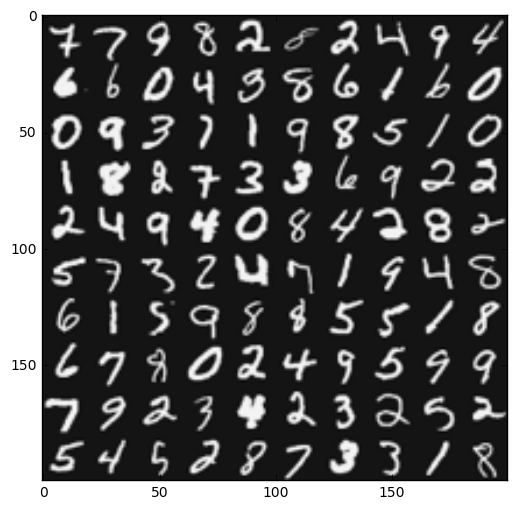

In [133]:
a = DisplayData(X)

### 1.3 Vectorizing Logistic Regression

Using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers

#### 1.3.1 Vectorizing the cost function

In [135]:
def sigmoid(z):
    sig = 1. / (1+ np.exp(-z))
    return sig

In [431]:
def lrCostFunction(theta, X, y, lamb):
    m = y.size                      # number of training examples
    h = sigmoid(np.dot(X, theta))

    J = -1*(1./m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)) + (lamb/(2.*m))*np.sum(np.square(theta[1:]))
    return J

cost = lrCostFunction(theta, X, y, 1)
cost

array([[ 160.39425758]])

#### 1.3.2 Vectorizing the gradient

In [494]:
def logistGradient(theta, X, y, lamb):
    m = y.size
    h = sigmoid(np.dot(X, theta.reshape(-1,1)))

    grad = (1./m) * (np.dot(X.T, (h - y))) + (lamb/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
    return grad.flatten()

grad = logistGradient(theta, X, y, 1)
grad[0:10]

array([ -5.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -7.74530186e-08,   3.19876600e-06,   1.89536237e-05,
        -7.06376094e-04,  -8.97395355e-04,  -3.72741263e-04,
        -1.10787541e-04])

### optional: test that cost and gradient functions are working correctly:

In [443]:
### test cases for gradient and cost functions
samp_X = np.array([[1, 8, 1, 6], [1,3,5,7], [1,4,9, 2]])
samp_y = np.matrix([1, 0, 1]).T
samp_theta = np.matrix([-2, -1, 1, 2]).T
samp_X.shape, samp_y.shape, samp_theta.shape

((3, 4), (3, 1), (4, 1))

In [492]:
# test cost function with test case from 'resources'
#lrCostFunction(samp_theta, samp_X, samp_y, 0) # should = 4.6832 : good!
lrCostFunction(samp_theta, samp_X, samp_y, 3)  # should = 7.6832 : good!

matrix([[ 7.68316655]])

In [461]:
# gradient test cases with samp_theta, samp_X, samp_y

#logistGradient(samp_theta, samp_X, samp_y, 0) # should = [0.31, 0.87, 1.6, 2.2] : good!
logistGradient(samp_theta, samp_X, samp_y, 3) # should = [0.31, -0.12, 2.6, 4.2] : good!

matrix([[ 0.31722075, -0.12768456,  2.6481235 ,  4.23787228]])

### 1.4 One-vs-all Classification

In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the K classes in our dataset. 

In [496]:
from scipy.optimize import minimize

def oneVsAll(X, y, lamb, K):
    m = X.shape[0]      # number of training examples = 5000
    n = X.shape[1]      # number of features = 401

    all_theta = np.zeros((K, n))   # initialize all_theta as 10 x 401 matrix of 0s
    initial_theta = np.zeros((n, 1)) # initialize theta as 401 x 1 matrix of 0s

    for i in range(1, K+1):
        results = minimize(lrCostFunction, initial_theta, args=(X, (y == i)*1, lamb), method=None,
                       jac= logistGradient, options={'maxiter':50})        #print results
        #print results.shape
        all_theta[i-1] = results.x
    return all_theta

optim_theta = oneVsAll(X, y, 0.1, 10)

#### 1.4.1 One-vs-all Prediction

In [497]:
def predictOneVsAll(all_theta, features):
    probabilities = sigmoid(np.dot(X, all_theta.T))
    
    return(np.argmax(probabilities, axis=1)+1)

prediction = predictOneVsAll(optim_theta, X)
print 'Training set accuracy: {} %'.format(np.mean(prediction == y.ravel())*100)

Training set accuracy: 93.24 %


## 2. Neural Networks

In the previous part of this exercise, you implemented multi-class logistic regression to recognize handwritten digits. However, logistic regression cannot form more complex hypotheses as it is only a linear classifier.

In this part of the exercise, you will implement a neural network to recognize handwritten digits using the same training set as before. For this week, you will use parameters from a neural network that we have already trained.

### 2.1 Model representation

Our neural network has 3 layers - an input layer, a hidden layer, and an output layer. Since our training images are of size 20 x 20, this gives us 400 input layer units.

In [502]:
# load pre-trained network parameters theta1, theta2

thetamatrix = scipy.io.loadmat('/Users/tess/Desktop/MachineLearning/machine-learning-ex3/ex3/ex3weights.mat')
theta1, theta2 = thetamatrix['Theta1'], thetamatrix['Theta2']

theta1.shape, theta2.shape

((25, 401), (10, 26))

### 2.2 Feedforward Propagation and Prediction

Use feedforward propagation to return the neural network's prediction

In [545]:
def nnPredict(theta1, theta2, X):
    m = X.shape[0]             # number of training examples
    n = theta2.shape[0]        # number of labels / categories to predict
    predict = np.zeros((m,1))  # initialize empty array of predictions
    a1 = X                     # we had already inserted 1 into position 0
    z2 = np.dot(theta1, a1.T)
    a2 = np.c_[np.ones((m,1)), sigmoid(z2).T]
    z3 = np.dot(a2, theta2.T)
    a3 = sigmoid(z3)
    
    predict = np.argmax(a3, axis =1)+1
    return predict

nnPrediction = nnPredict(theta1, theta2, X)
print 'Training set accuracy: {} %'.format(np.mean(nnPrediction == y.ravel())*100)

Training set accuracy: 97.52 %
